# Testing the normal form for the  reduced dynamics


We consider now a simple benchmark system

$$
\ddot{x} = x - x^3 - \delta\dot{x},
$$

which has fixed points at $x = \pm 1$. 

We will analyze the behavior near the fixed point $(x, \dot{x}) = (1, 0)$.

Note that in this problem there is no dimension reduction. The whole phase space is technically the slow 2D SSM of the fixed point. For this reason, this is a good candidate for benchmarking the normal form identification algorithm. 

In [1]:
import sympy as sy
time, x, xdot, delta = sy.symbols('t x_1 x_2 \\delta')

In [2]:
from sympy import latex
from IPython.display import display_latex



def disp(idx, symObj):
    eqn = '\\[' + idx + ' ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

In first order form, the vector field reads

In [3]:
RHS = sy.Matrix([xdot, x-x**3 - delta*xdot])
disp('\\frac{d}{dt}\\begin{pmatrix}x_1 \\\ x_2 \\end{pmatrix}=', RHS)

Its Jacobian at the fixed point is


In [4]:
J = RHS.jacobian([x, xdot]).subs([(x, 1), (xdot, 0)])

In [5]:
disp('J=', J)

which has eigenvalues

In [6]:
eigenvals = J.eigenvals(multiple = True)

In [7]:
for e in eigenvals:
    disp('\\lambda = ', e)

In the following, we fix $\delta = 0.1$, 

$$
\lambda = −0.05\pm1.41332940251026𝑖
$$

In [8]:
RHS.subs(delta, 0.1)

Matrix([
[                    x_2],
[-x_1**3 + x_1 - 0.1*x_2]])

In [9]:
vectorfield = sy.lambdify([time, [x, xdot]], RHS.subs(delta, 0.1))


In [10]:

def vectorfield(t,x):
    # needed to test regression
    # damped duffing oscillator with fixed points at x=0 and x=+/-1.
    # x[0] is position, x[1] is velocity
    return np.array([x[1], x[0]-x[0]**3 - 0.1*x[1]])


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [12]:
from scipy.optimize import minimize, least_squares
import ssmlearnpy.reduced_dynamics.normalform as normalform
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from scipy.io import savemat, loadmat

We choose two initial conditions in the basin of attraction of (1, 0) and integrate them in time numerically. 

In [13]:
t = np.linspace(0, 100, 1000)
dt = t[1] - t[0]
ic_0 = np.array([0.1, 0])
ic_1 = np.array([0.32, .1])
sol_0 = solve_ivp(vectorfield, [t[0], t[-1]], ic_0, t_eval=t)
sol_1 = solve_ivp(vectorfield, [t[0], t[-1]], ic_1, t_eval=t)
trajectories = [sol_0.y - np.array([1,0]).reshape(-1,1), sol_1.y - np.array([1,0]).reshape(-1,1)]
times = [t, t]

In [14]:
xx = np.linspace(-1.5, 1.5, 30)
yy = np.linspace(-1.5, 1.5, 30)
X, Y = np.meshgrid(xx, yy)
grid = np.vstack((X.ravel(), Y.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(X.shape)
V = V.reshape(X.shape)


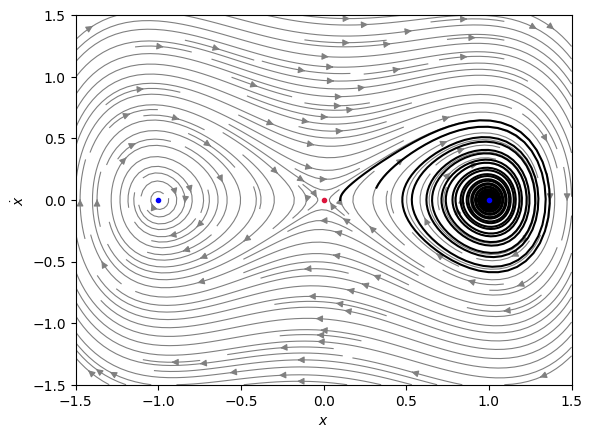

In [15]:
plt.streamplot(X, Y, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(1,0, '.', c='blue')
plt.plot(-1,0, '.', c='blue')


## Order 3 fit 

In [16]:

X, y  = shift_or_differentiate(trajectories, times, 'flow') 
# get an estimate for the linear part
#print(X[0].shape)
# add the constraints to the fixed points explicitly
constLHS = [[-1, 0]]
constRHS = [[0, 0]]
cons = [constLHS, constRHS]
# Fit reduced model
mdl = ridge.get_fit_ridge(X, y, poly_degree = 3, constraints = cons)
linearPart = mdl.map_info['coefficients'][:,:2]
dictTosave = {}
dictTosave['trajectories'] = trajectories
dictTosave['times'] = times
savemat('test_SSMLearn.mat', dictTosave)


INFO   2025-05-05 18:52:51 ridge Transforming data
INFO   2025-05-05 18:52:51 ridge Skipping CV on ridge regression
INFO   2025-05-05 18:52:51 ridge Using polynomial features degree 3
INFO   2025-05-05 18:52:51 ridge Fitting regression model
INFO   2025-05-05 18:52:51 ridge Adding constraints to regression model


In [17]:
ndofs = 1


In [18]:
nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = 3)
initial_guess = normalform.create_normalform_initial_guess(mdl, nf)



In [19]:
nf.tolerance

0.48474149478991313

In [20]:
np.random.seed(3)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)


With a 3rd order initial fit, the estimated linear part is accurate to within ~3%.

In [21]:
nf.LinearPart

array([[-0.04847415+1.41048855j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.04847415-1.41048855j]])

In [22]:
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, 3, d )

The trajectories can be plotted in the normal form coordinates

In [23]:
trajectories[0].shape

(2, 1000)

Text(0, 0.5, '$\\eta_2$')

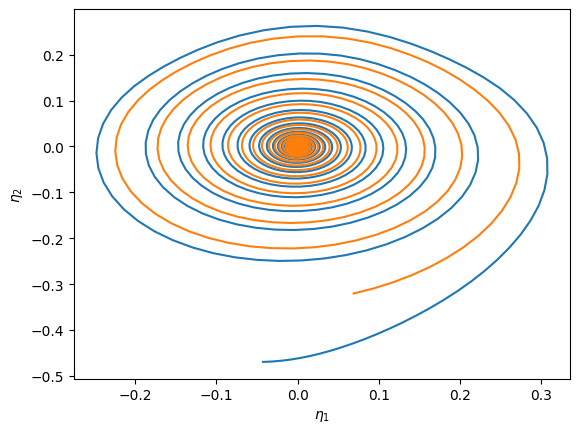

In [24]:
for t in trajectories:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')


In [25]:
time_pred = np.linspace(0, 100, 1000)
dt = t[1] - t[0]

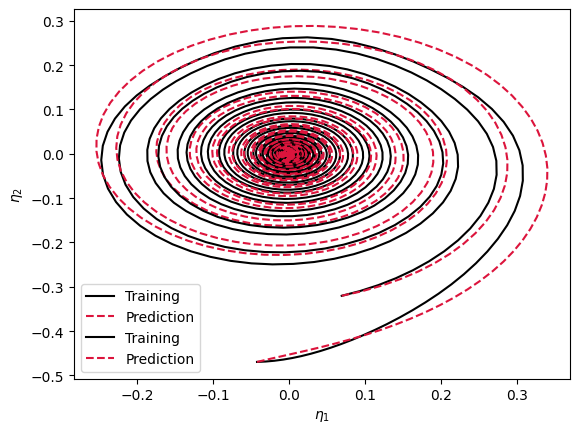

In [26]:

for t in trajectories:
    transformed = trf.inverse_transform(t)
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
    ic = transformed[:,0]
    
    pred = solve_ivp(dyn.map_info['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
    plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
    
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

## Increasing the order of approximation

We now compare the results with order = ${3,5,7,9}$

In [27]:
import logging


Let's disable the spam from the ridge regression infos

In [28]:
logger = logging.getLogger("ridge_regression")
logger.setLevel(logging.WARNING)

Order: 3, Residual: 0.10404862272842498 

Order: 5, Residual: 0.003972080772626707 

Order: 7, Residual: 0.0005385623008676086 

Order: 9, Residual: 0.00021876544319049504 



Text(0, 0.5, 'Relative error [%]')

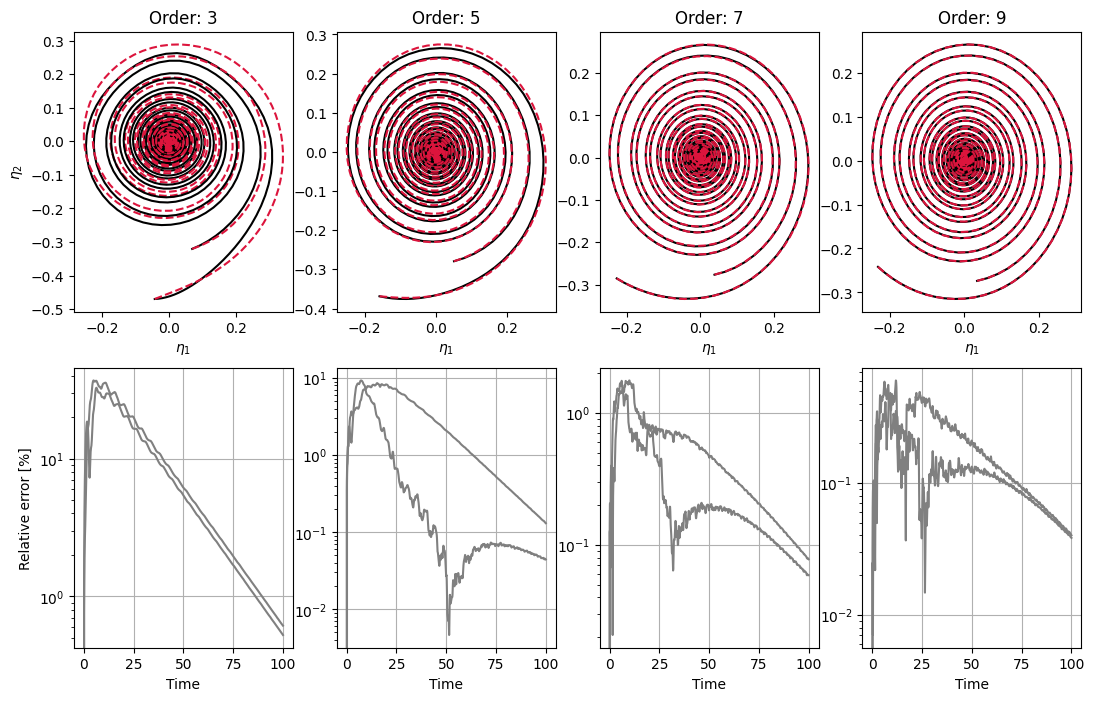

In [29]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn.map_info['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')



## Compare this against ```SSMLearn```

We have saved the exact same trajectories to a Matlab file, so that we can do the same predictions with SSMLearn. 

In [30]:

DataFromSSMlearn = loadmat('results_ssmlearn.mat')

In [31]:
zData = DataFromSSMlearn['predictions_zdata']
zRec = DataFromSSMlearn['predictions_zrec']


Text(0, 0.5, 'Relative error [%]')

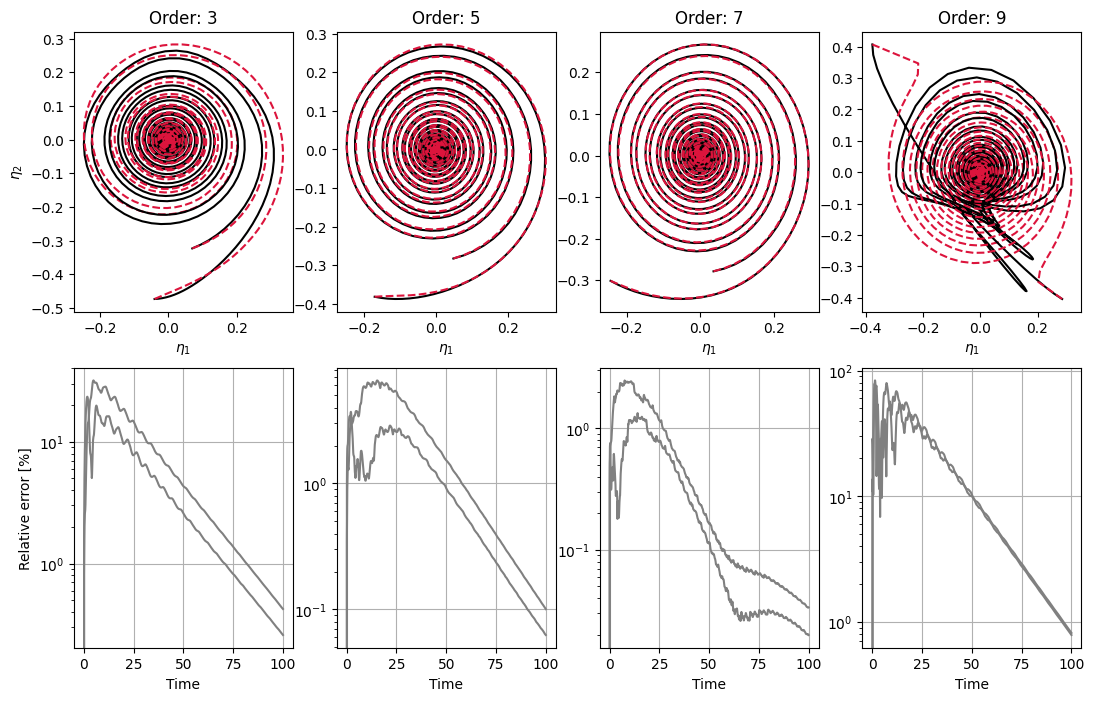

In [32]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for itraj in range(2):
        zdata = zData[i*2 + itraj, 1]
        zrec = zRec[i*2 + itraj, 1]
        time_ = zData[0,0][0,:]
        ax[0,i].plot(np.real(zdata[0,:]), np.imag(zdata[0,:]), '-', c='black', label = 'Training')
        ax[0,i].plot(np.real(zrec[0,:]), np.imag(zrec[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(zdata[0,:]))
        error = np.abs(zdata[0,:] - zrec[0,:])/tonorm
        ax[1,i].semilogy(time_, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')



### Over all, the results are comparable to SSMLearn

## Let's display the reduced dynamics at order 5

In [33]:
order = 5
mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
linearPart = mdl.map_info['coefficients'][:,:2]

nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
print('Order: %s, Residual: %s \n' %(order, res.cost))
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )


Order: 5, Residual: 0.003972080772626707 



In [34]:
import ssmlearnpy.utils.postprocessing as postprocessing

In [35]:
var, varbar, eqs = postprocessing.display_equation(dyn.map_info['coefficients'], dyn.map_info['exponents'], base_symbol='z', complex=True)



In [36]:
postprocessing.disp('\\dot{z}_0=', eqs[0])
postprocessing.disp('\\dot{\\bar{z}}_0=', eqs[1])

In [37]:
variables = [var[0], varbar[0]]

In [38]:
r, phi, req, phieq = postprocessing.convert_to_polar(variables, eqs)

In [39]:
postprocessing.disp('\\dot{r}_0=', req[0])
postprocessing.disp('\\dot{\\varphi}_0=', phieq[0])


In [40]:
import sympy as sy
toplot_backbone_curve = sy.lambdify(r[0], phieq[0])

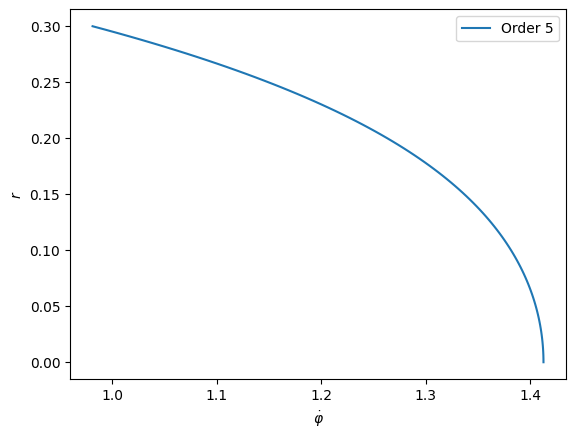

In [41]:
rtoplot = np.linspace(0, 0.3, 100)
plt.plot(toplot_backbone_curve(rtoplot), rtoplot,'-',label = 'Order 5')
plt.xlabel('$\\dot{\\varphi}$')
plt.ylabel('$r$')
plt.legend()